In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wisps
import wisps.simulations as wispsim
import matplotlib as mpl
import astropy.units as u
from astropy.coordinates import SkyCoord
import theano
import theano.tensor as tt
import pandas as pd
import pymc3 as pm
import seaborn as sns 
%matplotlib inline

In [2]:
COORDS=SkyCoord([p.coord for p in wisps.OBSERVED_POINTINGS ])

In [3]:
galc=COORDS.transform_to('galactic')

In [4]:
LS=galc.l.radian

In [5]:
BS=galc.b.radian

In [6]:
Rsun=8300.
Zsun=27.

In [7]:
#-------------------------------------------
def density_function(r, z, h):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    l = 2600. # radial length scale of exponential thin disk 
    zpart=np.exp(-abs(z-Zsun)/h)
    rpart=np.exp(-(r-Rsun)/l)
    return zpart*rpart

In [8]:
np.min(abs(BS))

0.35233193655075173

In [9]:
def sample_distances(dmax, nsample=1000):
    """
    sample the galaxy given a scale height
    
    """

    def logprior(l, b):
        return tt.switch(( abs(b) < 0.35),-np.inf, 0)
        
    def loglike(r, z, d, h):
        return np.log10((d**2)*density_function(r, z, h))
    
    def logp(l, b, r, z, d, h):
        return np.log10((d**2)*density_function(r, z, h))

    with pm.Model() as model:
        h=350.
        l=pm.Uniform('l', lower=-np.pi, upper=np.pi, testval=np.pi/2)
        b=pm.Uniform('b', lower=-np.pi/2, upper=np.pi/2, testval=np.pi/3)
    
        d=pm.Uniform('d', lower=0., upper=dmax, testval=dmax/2)
        
        x=pm.Deterministic('x',  Rsun-d*np.cos(b)*np.cos(l))
        y=pm.Deterministic('y', -d*np.cos(b)*np.sin(l))
        r=pm.Deterministic('r', (x**2+y**2)**0.5 )
        z=pm.Deterministic('z', Zsun+ d * np.sin(b))
        
        like = pm.DensityDist('likelihood', logp, observed={'l':l, 'b':b,
                             'r': r, 'z': z, 'd':d, 'h':h})

        trace = pm.sample(draws=int(nsample), cores=2)
    return trace, model


In [10]:
tr, model=sample_distances(16000, nsample=10000)

INFO (theano.gof.compilelock): Waiting for existing lock by process '37897' (I am process '40263')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/caganze/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [d, b, l]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:42<00:00, 493.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


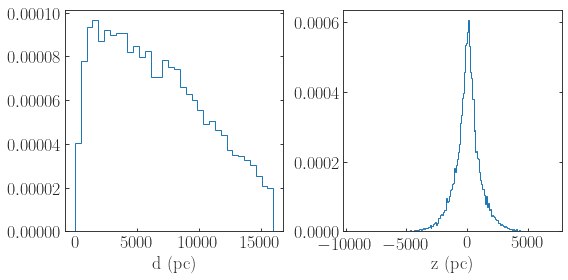

In [11]:

fig, ax=plt.subplots(ncols=2, figsize=(8, 4))
h=ax[0].hist(tr.d, histtype='step', normed=True, bins='auto')
h=ax[1].hist(tr.z, histtype='step', normed=True, bins='auto')
ax[0].set_xlabel('d (pc)',fontsize=18)
ax[1].set_xlabel('z (pc)',fontsize=18)


plt.tight_layout()

In [12]:
gc=SkyCoord(l=tr.l*u.rad, b=tr.b*u.rad, distance=tr.d*u.pc, frame='galactic')

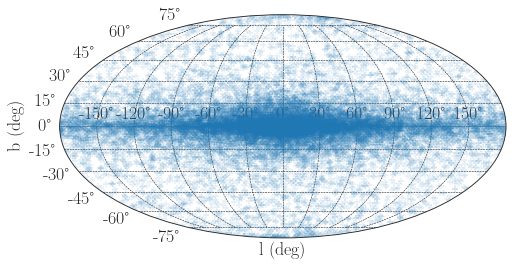

In [13]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(gc.l.wrap_at(180*u.degree).radian,gc.b.wrap_at(90*u.degree).radian, marker='+', alpha=0.1)
ax.set_xlabel('l (deg)', fontsize=18)
ax.set_ylabel('b (deg)', fontsize=18)
plt.grid()

In [14]:
kde1=wisps.kernel_density([tr.r, tr.z])
kde2=wisps.kernel_density([tr.x, tr.y])

In [15]:
dens1=kde1.pdf([tr.r, tr.z])
dens2=kde2.pdf([tr.x, tr.y])

In [16]:
cmap= sns.diverging_palette(100, 300, s=80, l=55, n=19, as_cmap=True)

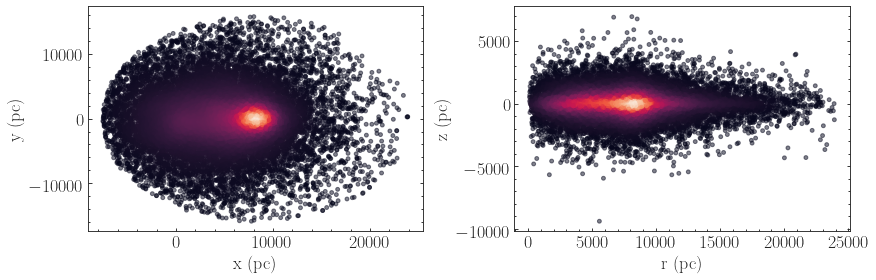

In [17]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
c=ax[0].scatter(tr.x, tr.y, c=dens2, s=15.,  alpha=0.5)
ax[0].set_xlabel('x (pc)', fontsize=18)
ax[0].set_ylabel('y (pc)', fontsize=18)

c=ax[1].scatter(tr.r, tr.z, c=dens1, s=15.,  alpha=0.5)
ax[1].set_xlabel('r (pc)', fontsize=18)
ax[1].set_ylabel('z (pc)', fontsize=18)


ax[0].minorticks_on()
ax[1].minorticks_on()

plt.tight_layout()

In [18]:
l=191.2747*u.deg.to(u.radian)
b=27.07427*u.deg.to(u.radian)
d=1000

x= Rsun-d*np.cos(b)*np.cos(l)
y=-d*np.cos(b)*np.sin(l)
r=(x**2+y**2)**0.5 
z=Zsun+ d * np.sin(b)

In [19]:
x, y, z, r

(9173.233201683659, 174.08825920621504, 482.1450905852515, 9174.88496355485)

In [20]:
np.arctan(y/x)

0.018975573833673428

In [21]:
wispsim.density_function(0, 0, h=350)

67688273350641.99

In [22]:
wispsim.density_function(27, 8300, h=350)

3926.679554054857

In [23]:
import itertools

In [24]:
c = list(itertools.product(dmaxses, lbses))

NameError: name 'dmaxses' is not defined

In [ ]:
c[0]

In [ ]:
import corner

In [ ]:
import astropy.units as u

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
for comb in c:
    tr, model=sample_distances( comb[1], comb[0],nsample=1000)
    fig, ax=plt.subplots(ncols=2, figsize=(8, 4))
    h=ax[0].hist(tr.d, histtype='step', normed=True, bins='auto')
    h=ax[1].hist(tr.z, histtype='step', normed=True, bins='auto')
    ax[0].set_xlabel('d (pc)',fontsize=18)
    ax[1].set_xlabel('z (pc)',fontsize=18)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    plt.tight_layout()
    fig.suptitle("dmax = {} l= {} b={}".format(comb[0]*u.pc, (comb[1][0]*u.rad).to(u.deg),(comb[1][1]*u.rad).to(u.deg)), 
                 fontsize=18)
    plt.tight_layout()


In [ ]:
#cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

In [ ]:
np.arctan( Zsun / Rsun)*u.radian.to(u.deg)